# CalTech 101 - Object classification

In this project, we're going to do object classification using Caltech 101 dataset. 
The dataset is available [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html#Discussion). The dataset contains images of 101 different objects, but isn't a large dataset.
The average size of image is 200x300
The average number of images per category is just about 50. 

In this notebook, we do the following:
1. Imports -- many libraries used for the construction of the models

2. Download the dataset from the URL and extract it using google drive

3. Exploring dataset -- Here, we write basic methods to read images programmatically and check their shapes. Further, we see how many images do we have per category.

4. Data processing -- When you wish to use any frameworks/tools and do some machine learning, you need to have your training data, and testing data in a standard format. We will be creating our X and Y here. For object categories, we turn them to one-hot encoded labels, and X is a normalized numpy image array.
Finally, we split the data to training and validation data. We choose 75% for training and 25% for validation purposes.

5. We try five different convolutional network approaches, categorical_crossentropy has been used as the loss function in both cases.

    1. The first Model] --- a simple CNN: input -> Convolution -> max-pooling -> flatten - > dense -> output
    
    2. The second Model Approach-2 ---Two convolutional layers - with the additoinal convolutional layer: input -> Convolution -> Convolution -> max-pooling -> flatten - > dense -> output

    3. The third Model Approach-3 ---Two convolutional layers with dropout - with the additon of dropout processs: input -> Convolution -> Convolution -> max-pooling -> flatten - > dense ->  dropout ->dense -> output

    4. The fourth Model Approach-4 ---Two cycles convolutional layers - no dropout, two cycles of convolutional layers and pooling: input -> Convolution -> Convolution -> max-pooling -> Convolution -> Convolution -> max-pooling -> flatten - > dense -> output

    5. The fifth Model Approach-5 ---Two cycles convolutional layers with dopout - added dropout:input -> Convolution -> Convolution -> max-pooling -> Convolution -> Convolution -> max-pooling -> flatten - > - > dense ->  dropout ->dense -> output

    
6. The average accuracy per category - On the [discussion page](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html#Discussion) of dataset, they suggest that to compare your results to existing papers, you should either use a specific number of training and testing examples OR, find accuracy per category and then average it out. In this section, we've tried finding average accuracy per category and it comes out to be about 83% for the models.

## All Imports and their reasons

In [2]:
import urllib.request
import os

# For extracting dataset
import tarfile

# For reading images
import cv2

# Essentials :)
import numpy as np
# pretty printing python objects
import pprint

# for sorting dictionary by value
import operator
# for showing images inline
from matplotlib.pyplot import imshow 
%matplotlib inline 

# for making labels one-hot encoded
from sklearn.preprocessing import LabelEncoder
import keras.utils

# for splitting data into training and validation data
from sklearn.model_selection import train_test_split

# for CNN and NN models

from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

# For transfer learning
from keras.applications.inception_v3 import InceptionV3

# to save models
import json

# for saving environment of notebook
import dill

# for printing size each variable is using
import sys
print("import done.")

import done.


## Download the dataset to a folder inside this directory

This will download the dataset if it has not been downloaded. Further, we extract the dataset as well into /data/ directory in the current working directory. 

In [3]:
URL_CALTECH_101_DATA = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
#using the drive id of the file to download from google drive
file_id = '137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp'
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id,
                                    dest_path='./dataset.tar.gz')
print("download done")


download done


In [4]:
def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction done")

extract_dataset('./dataset.tar.gz','./data/')


extraction done


## Exploring dataset

In [5]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [6]:
elephant_imgs = get_images('elephant','./data')

In [7]:
elephant_imgs[0]

'./data\\101_ObjectCategories\\elephant\\image_0001.jpg'

In [8]:
elephant_test_imgs = read_image(elephant_imgs[0])

In [9]:
elephant_test_imgs.shape

(200, 300, 3)

#### How many images we have for each category?

In [10]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [11]:
return_images_per_category('./data')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('kangaroo', 86),
 ('starfish', 86),
 ('trilobite', 86),
 ('buddha', 85),
 ('ewer', 85),
 ('sunflower', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('electric_guitar', 75),
 ('umbrella', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('dalmatian', 67),
 ('ferry', 67),
 ('flamingo', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('elephant', 64),
 ('euphonium', 64),
 ('joshua_tree', 64),
 ('soccer_ball', 64),
 ('stop_sign', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('cellphone', 59),
 ('rhino', 59),
 ('stegosaurus', 59),
 ('

In [12]:
len(return_images_per_category('./data'))

102

**The number of objects we need to classify is 101. So, we can actually ignore the BACKGROUND_Google directory**

## Creating Dataset for some ML

For machine learning, we need to convert the dataset into X and Y, wherein 

*X* would look something like **(num_of_total_images, ROWS, COLS, CHANNELS)** 

`The ROWS and COLS need to be fixed, however we have varied sized images. This is why the read_image method above resizes each image to 300x200 which is the average size of images (so most images wouldn't be affected).`

*Y* would be **(num_of_total_images, 1)**

**What's the total number of images we need in our dataset?**

In [13]:
total_count = 0
for category,count in return_images_per_category('./data'):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  8677


In [14]:
def create_training_data(data_directory):
    i = 0
    X = np.ndarray((8677, 200, 300, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X[i] = read_image(image)
            Y.insert(i,category) 
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [15]:
X, Y = create_training_data('./data')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

** Checking datasets sanity **

In [ ]:
X.shape

Let's check a random example and see if its class matches or not

In [18]:
Y[2323]

'Faces_easy'

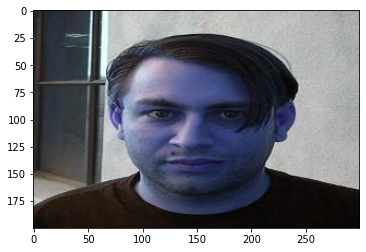

In [19]:
imshow(X[2323])

In [20]:
Y[1001]

'Motorbikes'

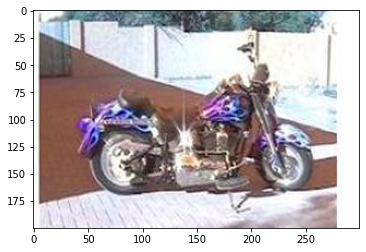

In [21]:
imshow(X[1001])

Seems all good. 

### Making one-hot encoded labels

In [16]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([ 5,  5,  5, ..., 52, 52, 52], dtype=int64)

In [18]:
np.save('label_encoder.npy', label_encoder.classes_)

In [24]:
len(Y_integer_encoded)

8677

In [25]:
len(Y)

8677

In [26]:
len(X)

8677

Integers have ordering property which we don't want our ML models to learn since an apple isn't in any way greater than an airplane.
So, we must create a one-hot encoding. 

In [22]:
from tensorflow.keras.utils import to_categorical
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
Y_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [24]:
len(Y_one_hot[0])

101

To get back the label for any one-hot encoded label

In [25]:
label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])

array(['airplanes'], dtype='<U15')

### Basic Normalization (in case of images)

In [28]:
X_normalized = X.astype(np.float64) / 255

In [26]:
X[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [27]:
X_normalized[0]

NameError: name 'X_normalized' is not defined

In [34]:
# We wouldn't require X anymore, so, let's free up some memory
del X

### Splitting the Data

In [29]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)

In [36]:
X_train.shape

(6507, 200, 300, 3)

In [37]:
Y_train.shape

(6507, 101)

Sanity Check

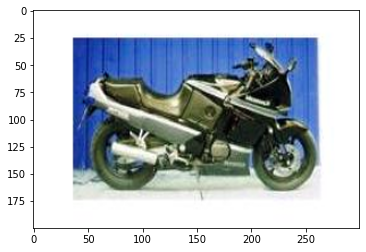

In [38]:
imshow(X_train[6001])

In [ ]:
## Approach 1 single convolutional layer

In [24]:

model_one_layer = Sequential()
model_one_layer.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_one_layer.add(MaxPooling2D(pool_size=2, strides=2))
model_one_layer.add(Flatten())
model_one_layer.add(Dense(101, activation='softmax'))
model_one_layer.summary()
model_one_layer.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
callbacks = [ModelCheckpoint('cnn_model.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_one_layer.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 149, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 236016)            0         
_________________________________________________________________
dense (Dense)                (None, 101)               23837717  
Total params: 23,838,165
Trainable params: 23,838,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
102/102 [==============================] - 76s 609ms/step - loss: 18.1174 - accuracy: 0.1550 - val_loss: 2.8689 - val_accuracy: 0.4687
Epoch 2/10
102/102 [==============================] - 55s 543ms/step - loss: 1.0281 - accuracy: 

In [ ]:
## Approach 2 two layers

In [1]:

model_two_layers = Sequential()
model_two_layers.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_two_layers.add(Conv2D(32, (3,3), activation='relu'))
model_two_layers.add(MaxPooling2D(pool_size=2, strides=2))
model_two_layers.add(Flatten())
model_two_layers.add(Dense(101, activation='softmax'))
model_two_layers.summary()
model_two_layers.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
callbacks = [ModelCheckpoint('cnn_model.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_two_layers.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)


NameError: name 'Sequential' is not defined

In [29]:
## Approach 3 two layers dropout

In [30]:

model_two_layers_dropout = Sequential()
model_two_layers_dropout.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_two_layers_dropout.add(Conv2D(32, (3,3), activation='relu'))
model_two_layers_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_two_layers_dropout.add(Flatten())
model_two_layers_dropout.add(Dense(256, activation='relu'))
model_two_layers_dropout.add(Dropout(0.5))
model_two_layers_dropout.add(Dense(101, activation='softmax'))
model_two_layers_dropout.summary()
model_two_layers_dropout.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
callbacks = [ModelCheckpoint('cnn_model.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_two_layers_dropout.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 298, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 196, 296, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 148, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 464128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               118817024 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 101)              

In [31]:
model_two_layers_dropout.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)


Epoch 1/10
102/102 [==============================] - 245s 2s/step - loss: 0.3880 - accuracy: 0.8910 - val_loss: 2.7786 - val_accuracy: 0.4880
Epoch 2/10
102/102 [==============================] - 220s 2s/step - loss: 0.3633 - accuracy: 0.8983 - val_loss: 2.6231 - val_accuracy: 0.4945
Epoch 3/10
102/102 [==============================] - 219s 2s/step - loss: 0.3390 - accuracy: 0.9044 - val_loss: 2.7984 - val_accuracy: 0.4885
Epoch 4/10
102/102 [==============================] - 206s 2s/step - loss: 0.3062 - accuracy: 0.9107 - val_loss: 2.9224 - val_accuracy: 0.4843
Epoch 5/10
102/102 [==============================] - 213s 2s/step - loss: 0.2887 - accuracy: 0.9147 - val_loss: 3.0062 - val_accuracy: 0.5037
Epoch 6/10
102/102 [==============================] - 215s 2s/step - loss: 0.2923 - accuracy: 0.9176 - val_loss: 3.1858 - val_accuracy: 0.4986
Epoch 00006: early stopping


In [ ]:
## Approach 4 two cycles CNN

In [39]:
model_two_cycles = Sequential()
model_two_cycles.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_two_cycles.add(Conv2D(32, (3,3), activation='relu'))
model_two_cycles.add(MaxPooling2D(pool_size=2, strides=2))
model_two_cycles.add(Conv2D(64, (3,3), activation='relu'))
model_two_cycles.add(Conv2D(128, (3,3), activation='relu'))
model_two_cycles.add(MaxPooling2D(pool_size=2, strides=2))
model_two_cycles.add(Flatten())
model_two_cycles.add(Dense(101, activation='softmax'))
model_two_cycles.summary()
model_two_cycles.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
callbacks = [ModelCheckpoint('cnn_model.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_two_cycles.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 298, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 296, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 148, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 146, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 144, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 72, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 433152)            0

## Approach 5 two cycles CNN with dropout

In [44]:
# Architecture
model_two_cycles_dropout = Sequential()
model_two_cycles_dropout.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,300,3)))
model_two_cycles_dropout.add(Conv2D(32, (3,3), activation='relu'))
model_two_cycles_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_two_cycles_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_two_cycles_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_two_cycles_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_two_cycles_dropout.add(Flatten())
model_two_cycles_dropout.add(Dense(512, activation='relu'))
model_two_cycles_dropout.add(Dropout(0.5))
model_two_cycles_dropout.add(Dense(101, activation='softmax'))
model_two_cycles_dropout.summary()

# loss and optimizer
model_two_cycles_dropout.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# training
callbacks = [ModelCheckpoint('cnn_model_dropout_two.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
model_two_cycles_dropout.fit(X_train, Y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 298, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 196, 296, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 148, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 146, 64)       18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 94, 144, 64)       36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 72, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 216576)           

In [77]:
# Train some more as val accuracy seems to be improving even though it still looks like overfit
model_two_cycles_dropout.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/10
407/407 [==============================] - 562s 1s/step - loss: 0.1338 - accuracy: 0.9633 - val_loss: 2.8094 - val_accuracy: 0.5419
Epoch 2/10
407/407 [==============================] - 523s 1s/step - loss: 0.1138 - accuracy: 0.9733 - val_loss: 2.7846 - val_accuracy: 0.5475
Epoch 3/10
407/407 [==============================] - 519s 1s/step - loss: 0.0811 - accuracy: 0.9797 - val_loss: 2.7896 - val_accuracy: 0.5382
Epoch 4/10
407/407 [==============================] - 555s 1s/step - loss: 0.0684 - accuracy: 0.9832 - val_loss: 2.6700 - val_accuracy: 0.5664
Epoch 5/10
407/407 [==============================] - 618s 2s/step - loss: 0.0439 - accuracy: 0.9891 - val_loss: 2.8801 - val_accuracy: 0.5512
Epoch 6/10
407/407 [==============================] - 600s 1s/step - loss: 0.0478 - accuracy: 0.9885 - val_loss: 2.8247 - val_accuracy: 0.5530
Epoch 7/10
407/407 [==============================] - 566s 1s/step - loss: 0.0333 - accuracy: 0.9919 - val_loss: 2.8196 - val_accuracy: 0.5576

KeyboardInterrupt: 

## Prediction from the models

#### Predicting for one image

In [48]:
dolphin_imgs = get_images('dolphin','./data')

In [49]:
dolphin_imgs[0]

'./data\\101_ObjectCategories\\dolphin\\image_0001.jpg'

In [50]:
img = read_image(dolphin_imgs[0])

In [51]:
img.shape

(200, 300, 3)

In [52]:
img = img.reshape((1,200,300,3))

In [64]:
prediction = model_two_cycles_dropout.predict(img)

In [65]:
label_predicted = label_encoder.inverse_transform([np.argmax(prediction)])
print(label_predicted)

['dolphin']


In [ ]:
for var, obj in locals().items():
    print(var, sys.getsizeof(obj))

## Accuracy per category

In [33]:
def find_accuracy_per_category(data_directory, nn_model):
    category_accuracy_dict = {}
    for category,count in return_images_per_category(data_directory):
        correctly_classified = 0
        if category == 'BACKGROUND_Google':
            continue
        Y_category = [category for _ in range(count)]
        encoded = label_encoder.transform(Y_category)
        Y_category = to_categorical(encoded, num_classes=101)
        assert Y_category.shape == (count, 101)
        X_category = np.ndarray((count, 200, 300, 3), dtype=np.float64)
        for i,img in enumerate(get_images(category, data_directory)):
            if not img.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X_category[i] = read_image(img) / 255
        score = nn_model.evaluate(x=X_category, y=Y_category, verbose=1)
        del X_category
        category_accuracy_dict[category] = score
    print("Accuracy found for each class")
    return category_accuracy_dict

In [31]:
# Free memory - those variables which aren't needed
del X
del X_normalized

In [34]:
def find_average_accuracy_for_model(data_directory, nn_model):
    category_accuracy_dict = find_accuracy_per_category('./data', nn_model)
    average_accuracy = 0
    for category, scores in category_accuracy_dict.items():
        print(category,":",scores[1])
        average_accuracy += scores[1]
    average_accuracy /= 101
    print("Average accuracy : ",average_accuracy)

In [36]:
## Find the average categorical accuracy for each model

1/1 [==============================] - 0s 206ms/step - loss: 1.7212 - accuracy: 0.7419
Accuracy found for each class
airplanes : 0.9900000095367432
Motorbikes : 0.9962406158447266
Faces : 0.9724137783050537
Faces_easy : 0.9908046126365662
watch : 0.9372385144233704
Leopards : 0.9950000047683716
bonsai : 0.890625
car_side : 0.9918699264526367
ketch : 0.9473684430122375
chandelier : 0.8598130941390991
hawksbill : 0.8700000047683716
grand_piano : 0.9595959782600403
brain : 0.8979591727256775
butterfly : 0.8571428656578064
helicopter : 0.7840909361839294
menorah : 0.8275862336158752
kangaroo : 0.8488371968269348
starfish : 0.8488371968269348
trilobite : 0.9534883499145508
buddha : 0.8470588326454163
ewer : 0.8117647171020508
sunflower : 0.8470588326454163
scorpion : 0.761904776096344
revolver : 0.9024389982223511
laptop : 0.790123462677002
ibis : 0.8500000238418579
llama : 0.807692289352417
minaret : 0.9473684430122375
electric_guitar : 0.7599999904632568
umbrella : 0.8266666531562805
crab

In [70]:

find_average_accuracy_for_model('./data',model_one_layer)
find_average_accuracy_for_model('./data',model_two_layers)
find_average_accuracy_for_model('./data',model_two_layers_dropout)
find_average_accuracy_for_model('./data',model_two_cycles)
find_average_accuracy_for_model('./data',model_two_cycles_dropout)


==============] - 1s 404ms/step - loss: 0.7240 - accuracy: 0.8438
1/1 [==============================] - 0s 386ms/step - loss: 1.4206 - accuracy: 0.7742
Accuracy found for each class
airplanes : 0.9574999809265137
Motorbikes : 0.9949874877929688
Faces : 0.9885057210922241
Faces_easy : 0.9839080572128296
watch : 0.9414225816726685
Leopards : 0.9750000238418579
bonsai : 0.84375
car_side : 0.9268292784690857
ketch : 0.9210526347160339
chandelier : 0.8785046935081482
hawksbill : 0.8799999952316284
grand_piano : 0.9494949579238892
brain : 0.918367326259613
butterfly : 0.8571428656578064
helicopter : 0.75
menorah : 0.8505747318267822
kangaroo : 0.7906976938247681
starfish : 0.9069767594337463
trilobite : 0.930232584476471
buddha : 0.800000011920929
ewer : 0.7764706015586853
sunflower : 0.9529411792755127
scorpion : 0.75
revolver : 0.9390243887901306
laptop : 0.8641975522041321
ibis : 0.762499988079071
llama : 0.8205128312110901
minaret : 0.9736841917037964
electric_guitar : 0.746666669845581

1/1 [==============================] - 0s 203ms/step - loss: 0.6970 - accuracy: 0.9032
Accuracy found for each class
airplanes : 0.987500011920929
Motorbikes : 0.9937343597412109
Faces : 0.931034505367279
Faces_easy : 0.9977011680603027
watch : 0.9288703203201294
Leopards : 1.0
bonsai : 0.9296875
car_side : 1.0
ketch : 0.9473684430122375
chandelier : 0.9532710313796997
hawksbill : 0.8899999856948853
grand_piano : 0.939393937587738
brain : 0.9387755393981934
butterfly : 0.901098906993866
helicopter : 0.7840909361839294
menorah : 0.9195402264595032
kangaroo : 0.8023256063461304
starfish : 0.8255813717842102
trilobite : 0.9186046719551086
buddha : 0.8823529481887817
ewer : 0.8823529481887817
sunflower : 0.9764705896377563
scorpion : 0.761904776096344
revolver : 0.9268292784690857
laptop : 0.8765432238578796
ibis : 0.7749999761581421
llama : 0.8461538553237915
minaret : 0.9473684430122375
electric_guitar : 0.8399999737739563
umbrella : 0.8133333325386047
crab : 0.835616409778595
crayfish :

## What else can we do?

Due to time constraints there are a lot of things I couldn't try right now, however could be done to : 

**Improve our object classification**
- I'm certain that our CNN models could be optimized further. The dataset is quite an easy one compared to likes of imagenet, so a simple model should be able to work quite well if optimized well
- Add visualizations of losses and training and predictions
- Try other algorithms and other NN architectures

**Do Object Detection**
Currently, if you look at this dataset, most of the images are clutter free, containing image of only one object, which is also centered in most of the cases. This makes this dataset less challenging for object detection problem. Also, one could perhaps just have a bad version of sliding window or R-CNN algorithm which could do detection problem here and give good boundary boxes.

However, to improve upon that, YOLO and SSD algorithms could be used to detect where which object is in an image. 